In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((200,200)),
    transforms.ToTensor()])

In [3]:
from spikingjelly.activation_based import neuron,functional

In [4]:
def ratecoding(x,T):
    probs=x.repeat(T,1,1,1,1)
    spikes=(torch.rand_like(probs)<probs).float()
    return spikes

In [5]:
img=Image.open("traffic.jpg")
x=transform(img)

In [6]:
T=200
spikeinput=ratecoding(x,T)

sobelx=torch.tensor([[
    [[-1,0,1],
     [-2,0,2],
     [-1,0,1]]
]],dtype=torch.float32)

sobely=torch.tensor([[
    [[-1,-2,1],
     [0,0,0],
     [1,2,1]]
]],dtype=torch.float32)

In [7]:
class lifneuron(nn.Module):
    def __init__(self,tau=2.0,threshold=0.5):
        super().__init__()
        self.tau=tau
        self.threshold=threshold
        self.v=None

    def forward(self,x):
        if self.v is None:
            self.v = torch.zeros_like(x)
        self.v = self.v +(x-self.v)/self.tau
        out=(self.v >= self.threshold).float()
        self.v = self.v * (1-out)
        return out

In [8]:
class sobelsnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.convx = nn.Conv2d(1, 1, 3, bias=False, padding=1)
        self.convy = nn.Conv2d(1, 1, 3, bias=False, padding=1)
        self.convx.weight.data = sobelx
        self.convy.weight.data = sobely
        self.lifx = lifneuron()
        self.lify = lifneuron()

    def forward(self, spikeseq):
        outx, outy = [], []
        for t in range(spikeseq.shape[0]):
            xt = self.convx(spikeseq[t])
            yt = self.convy(spikeseq[t])
            outx.append(self.lifx(xt))
            outy.append(self.lify(yt))
        return torch.stack(outx), torch.stack(outy)      

In [9]:
model = sobelsnn()
outx, outy = model(spikeinput)
edgex = outx.mean(0).squeeze().detach().numpy()
edgey = outy.mean(0).squeeze().detach().numpy()
edgemag = (edgex**2 + edgey**2)**0.5

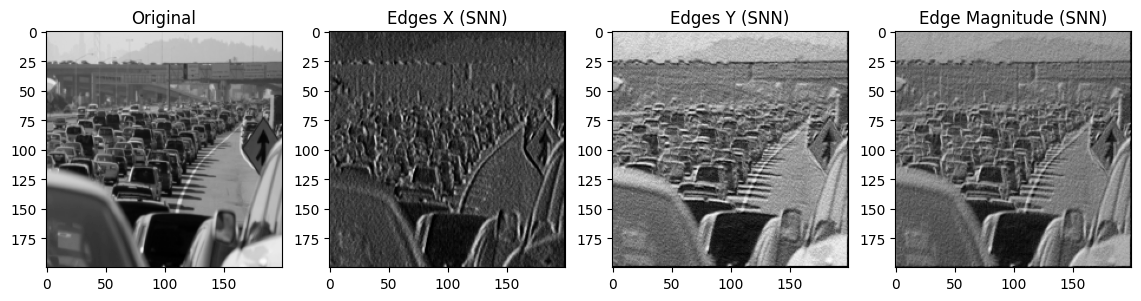

In [10]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1);
plt.imshow(x.squeeze().numpy(), cmap='gray');
plt.title("Original")
plt.subplot(1, 4, 2); 
plt.imshow(edgex, cmap='gray'); 
plt.title("Edges X (SNN)") 
plt.subplot(1, 4, 3);
plt.imshow(edgey, cmap='gray'); 
plt.title("Edges Y (SNN)")
plt.subplot(1, 4, 4); 
plt.imshow(edgemag, cmap='gray'); 
plt.title("Edge Magnitude (SNN)")
plt.show()

In [11]:
import torch.nn.functional as F
import math

In [12]:
def sobel_classical(img):  # img: [1,1,H,W]
    sobelx = torch.tensor([[
        [[-1,0,1],
         [-2,0,2],
         [-1,0,1]]
    ]], dtype=torch.float32, device=img.device)

    sobely = torch.tensor([[
        [[-1,-2,-1],
         [0,0,0],
         [1,2,1]]
    ]], dtype=torch.float32, device=img.device)

    gx = F.conv2d(img, sobelx, padding=1)
    gy = F.conv2d(img, sobely, padding=1)
    mag = torch.sqrt(gx**2 + gy**2 + 1e-8)  # epsilon avoids nan
    return mag

In [13]:
x_input = x.unsqueeze(0)  # [1,1,200,200]
Mag_class = sobel_classical(x_input)
Mag_class = Mag_class.squeeze().detach().cpu().numpy()

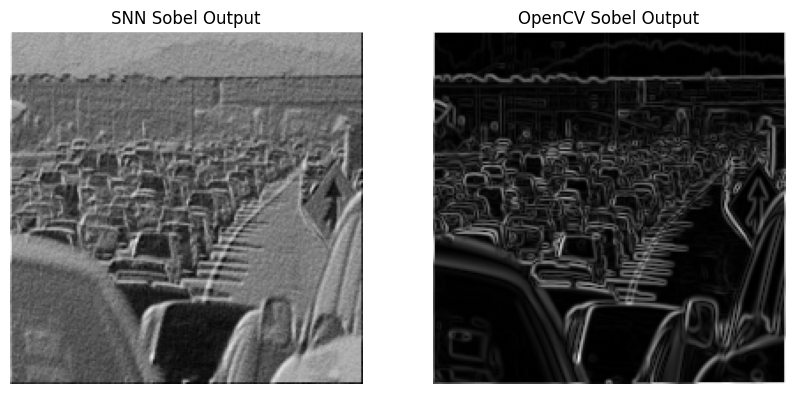

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("SNN Sobel Output")
plt.imshow(edgemag, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("OpenCV Sobel Output")
plt.imshow(Mag_class, cmap='gray')
plt.axis('off')

plt.show()

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(input_tensor, snn_output, classical_output, titles=("Input", "SNN Output", "Classical Output")):
    """
    Plots input, SNN output, and Classical output side-by-side with heatmaps.
    Works if inputs are torch tensors or numpy arrays.
    """

    def prepare_img(tensor):
        if isinstance(tensor, torch.Tensor):
            img = tensor.detach().cpu()
            if img.dim() == 3:  # [C,H,W] → [H,W,C]
                img = img.permute(1, 2, 0)
            img = img.numpy()
        elif isinstance(tensor, np.ndarray):
            img = tensor
        else:
            raise TypeError(f"Unsupported type: {type(tensor)}")
        return img

    # Convert to numpy
    inp = prepare_img(input_tensor)
    snn = prepare_img(snn_output)
    classical = prepare_img(classical_output)

    # Plot side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    images = [inp, snn, classical]

    for ax, img, title in zip(axes, images, titles):
        heatmap = ax.imshow(img, cmap="viridis")
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


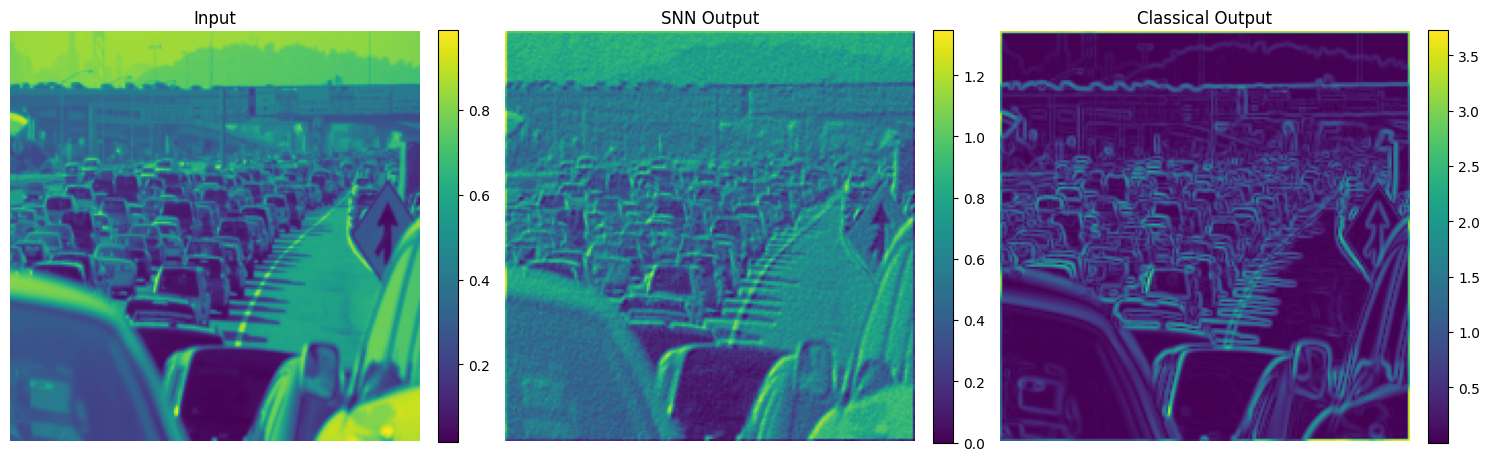

In [20]:
plot_comparison(x, edgemag, Mag_class)